In [1]:
import numpy as np

def str_to_matrix(state):
    k = 0;
    mat = np.zeros((3, 3), dtype=np.int32)
    for i in range(3):
        for j in range(3):
            mat[i][j] = state[k]
            k += 1
    return mat

def matrix_to_str(mat):
    s = ""
    for t in mat.reshape(9,):
        s += (str)(t)
    return s

def get_zero_index(state):
    ind = 0
    for ch in state:
        if(ch=='0'):
            return ind
        ind += 1

In [2]:
# move '0' in possible directions 
def expand(state):

    # neighbour configurations
    neighbours = []

    # create matrix
    mat = str_to_matrix(state)

    # find index of '0'
    index = get_zero_index(state)
    
    # row and col index of '0'
    i = (int)(index / 3) # row
    j = index % 3; # col

    # move up if possible
    if(i!=0):
        temp_mat = np.copy(mat)
        temp_mat[i][j] = temp_mat[i-1][j]
        temp_mat[i-1][j] = 0
        state = matrix_to_str(temp_mat)
        neighbours.append(state)

    # move down if possible
    if(i!=2):
        temp_mat = np.copy(mat)
        temp_mat[i][j] = temp_mat[i+1][j]
        temp_mat[i+1][j] = 0
        state = matrix_to_str(temp_mat)
        neighbours.append(state)

    # move left if possible
    if(j!=0):
        temp_mat = np.copy(mat)
        temp_mat[i][j] = temp_mat[i][j-1]
        temp_mat[i][j-1] = 0
        state = matrix_to_str(temp_mat)
        neighbours.append(state)

    # move right if possible
    if(j!=2):
        temp_mat = np.copy(mat)
        temp_mat[i][j] = temp_mat[i][j+1]
        temp_mat[i][j+1] = 0
        state = matrix_to_str(temp_mat)
        neighbours.append(state)

    return neighbours

In [3]:
from collections import deque
from collections import defaultdict
from queue import PriorityQueue

class solver(object):
    
    def __init__(self):
        self.fringe = PriorityQueue()
        self.g = defaultdict(int)
        self.visited = defaultdict(bool)
        self.cameFrom = {}
        
        self.interations = 0
        self.max_fringe_size = -float('inf') 
        self.fringe_growth = []
        
    def stats(self):
        print("iterations : ", self.interations)
        print("final_fringe_size : ", self.fringe.qsize())
        print("max_fringe_size : ", self.max_fringe_size)
        print("total nodes visited : ", len(self.visited))
               
    def reconstruct_path(self, current):
        total_path = deque([current])
        while current in self.cameFrom.keys():
            current = self.cameFrom[current]
            total_path.appendleft(current)
        return total_path
    
    def modified_expand(self, S, depth):
        self.visited[S] = True  
        temp1 = deque([S])
        while depth > 0 :
            temp2 = []
            while len(temp1) :    
                C = temp1.popleft()

                if C == '012345678':
                    temp1.appendleft(C)
                    return temp1

                temp3 = filter(lambda x: not self.visited[x] 
                               or self.g[x]>self.g[C]+1, expand(C))
                temp3 = list(temp3)
                for t in temp3:
                    self.g[t] = self.g[C] + 1
                    self.cameFrom[t] = C
                    self.visited[t] = True
                temp2.extend(temp3)

            depth -= 1
            temp1 = deque(temp2)
        return temp1

    def modified_astar(self, I, h, depth):
        self.g[I] = 0  
        self.interations = 0
        S = I
        while S != "012345678" :
            temp = self.modified_expand(S, depth)
            for T in temp:
                f = self.g[T] + h(T)
                self.fringe.put((f, T)) 

            if self.fringe.qsize() > self.max_fringe_size :
                self.max_fringe_size = self.fringe.qsize()
                
            self.fringe_growth.append(self.fringe.qsize())
            
            if self.fringe.empty():
                return []

            S = self.fringe.get()[1]
            self.interations += 1

        return self.reconstruct_path("012345678")

In [4]:
# manhatten distance sum heuristic
def manhattan_distance(state):
    ij = [0 for i in range(9)]
    for index, ch in enumerate(state):      
        i = (int)(index / 3) # row
        j = index % 3; # col
        ij[(int)(ch)] = ((i,j))
    
    dist_sum = 0
    for index in range(1,9):
        i = (int)(index / 3) # row
        j = index % 3; # col
        dx = abs(i - ij[index][0])
        dy = abs(j - ij[index][1])
        dist = dx + dy      
        dist_sum += dist
    
    return dist_sum

In [5]:
# tile mismatch count heuristic
def tile_mismatch(state):
    mismatch = 0
    goal = "012345678"
    for i in range(9):
        if goal[i] != state[i]:
            mismatch += 1
    return mismatch

In [6]:
initial_state = "321478650"
depth = 2
# A* using manhattan_distance heuristic
solver11 = solver()
solver11.modified_astar(initial_state, manhattan_distance, depth)
s11 = solver11.fringe_growth

solver12 = solver()
solver12.modified_astar(initial_state, manhattan_distance, 1)
s12 = (solver12.fringe_growth)

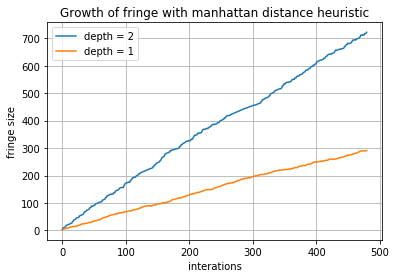

In [71]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = min(solver11.interations, solver12.interations)
t = np.arange(x)

fig, ax = plt.subplots()
ax.plot(t, s11[0:x], label=f'depth = {depth}')
ax.plot(t, s12[0:x], label='depth = 1') 

ax.set(xlabel='interations', ylabel='fringe size',
       title='Growth of fringe with manhattan distance heuristic')
ax.grid()
ax.legend()

fig.savefig("manhattan_depth_cmp.png")
plt.show()

In [67]:
initial_state = "321478650"
depth = 2
# A* using tile mis-match heuristic
solver21 = solver()
path21 = solver21.modified_astar(initial_state, tile_mismatch, depth)
s21 = (solver21.fringe_growth)

solver22 = solver()
path22 = solver22.modified_astar(initial_state, tile_mismatch, 1)
s22 = (solver22.fringe_growth)

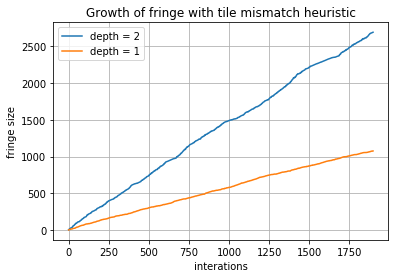

In [72]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
y = min(solver21.interations, solver22.interations)
t = np.arange(y)

fig, ax = plt.subplots()
ax.plot(t, s21[0:y], label=f'depth = {depth}')
ax.plot(t, s22[0:y], label='depth = 1') 

ax.set(xlabel='interations', ylabel='fringe size',
       title='Growth of fringe with tile mismatch heuristic')
ax.grid()
ax.legend()

fig.savefig("tilemismatch_depth_cmp.png")
plt.show()

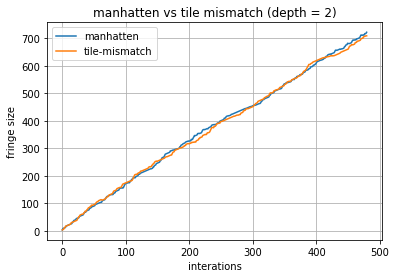

In [73]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
z = min(solver11.interations, solver21.interations) 
t = np.arange(z)

fig, ax = plt.subplots()
ax.plot(t, s11[0:z], label='manhatten')
ax.plot(t, s21[0:z], label='tile-mismatch') 

ax.set(xlabel='interations', ylabel='fringe size',
       title=f'manhatten vs tile mismatch (depth = {depth})')
ax.grid()
ax.legend()

fig.savefig("heuristic_cmp_depth_d.png")
plt.show()

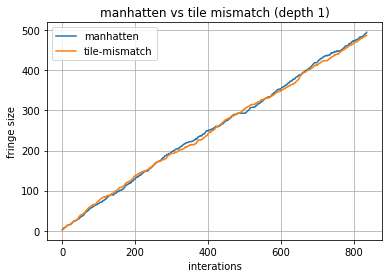

In [74]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
z = min(solver12.interations, solver22.interations) 
t = np.arange(z)

fig, ax = plt.subplots()
ax.plot(t, s12[0:z], label='manhatten')
ax.plot(t, s22[0:z], label='tile-mismatch') 

ax.set(xlabel='interations', ylabel='fringe size',
       title='manhatten vs tile mismatch (depth 1)')
ax.grid()
ax.legend()

fig.savefig("heuristic_cmp_depth_1.png")
plt.show()

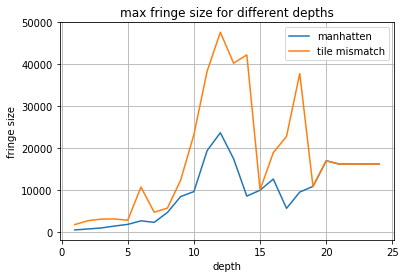

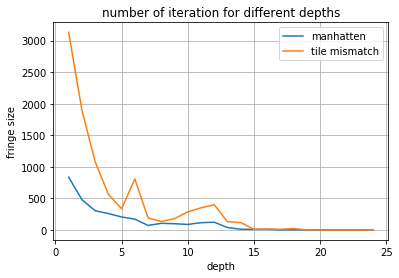